<a href="https://colab.research.google.com/github/Lampc/NBARNN/blob/main/NBA_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the Data

The best place we found for large-scale datasets of NBA player stats was NBA.com. However, it is paywalled/heavily limited in terms of access without a prior letter to their office, which we could not feasibly do. So, after some digging, we found the NBA_API github, which thankfully did have back-end access to the dataset we wanted to get. Right under this, are the 2 Colab Installations for nba_api(which is the aforementioned github repo), and tqdm, which is a progress bar that we used to track the progress of the download of the dataset.

In [ ]:
#installation of api access and tqdm for progress bar
!pip install nba_api
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.7/261.7 kB 2.1 MB/s eta 0:00:00


# Accessing the API

Once we installed the 2 packages, we then imported the playercareerstats and static players.py datasets, pandas for data manipulation, tqdm to serve as a progress bar, and ReadTimeout to let us know if there were any issues with getting all of the data from the API. Then, we saved the end dataframe to a csv.

In [ ]:
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.static import players
import pandas as pd
from tqdm import tqdm
from requests.exceptions import ReadTimeout


#obtaining data from nba_api, standard json access and conversion code
def fetch_player_career_stats(player_id, timeout=None):
    max_retries = 3
    retries = 0
    while retries < max_retries:
        try:
            player_career = playercareerstats.PlayerCareerStats(
                player_id=player_id,
                timeout=timeout
            )
            return player_career.get_data_frames()[0]
        except ReadTimeout as e:
            retries += 1
            print(f"Read timeout. Retrying... (Attempt {retries}/{max_retries})")
    raise Exception("Failed to fetch data after multiple retries.")

# Timeout
timeout = 100

# Get all players
all_players = players.get_players()

# Initialize an empty list to store player dfs
career_dfs = []

# using tqdm to measure conversion process
for player in tqdm(all_players, desc="Processing Players"):
    player_id = player['id']

    # Get player career stats with custom settings
    try:
        career_df = fetch_player_career_stats(
            player_id=player_id,
            timeout=timeout
        )
    except Exception as e:
        print(f"Error fetching data for Player ID {player_id}: {e}")
        continue

    # make sure df is applicable for our criteria of 5 Y period
    if any((career_df['SEASON_ID'] >= '2018') & (career_df['SEASON_ID'] <= '2023')):

        # Filter df for 2018-2023
        mask = (career_df['SEASON_ID'] >= '2018') & (career_df['SEASON_ID'] <= '2023')
        career_df_filtered = career_df.loc[mask].copy()

        # Add player to df
        career_df_filtered['Player_ID'] = player_id
        career_df_filtered['Player_Name'] = player['full_name']

        # Append df to the list
        career_dfs.append(career_df_filtered)

#combining all dfs
all_players_df = pd.concat(career_dfs, ignore_index=True)

#saving to csv
all_players_df.to_csv('all_players_career_stats_2018_2023.csv', index=False)

# Feature Selection
After downloading the csv of player stats (it was a json but we converted it so we could easier integrate it with pandas), we ran some basic statistical tests on the numeric variables (since there were only 5 years anyway, so things like player name and years played would have a negative effect on the efficacy of the model). The goal here was to determine which values had the highest correlation to Assists, which were our value we were trying to predict.

In [ ]:
import pandas as pd

all_players_df = pd.read_csv("/content/all_players_career_stats_2018_2023.csv")
all_players_df.head()

# Assuming your target variable is 'AST'
target_variable = 'AST'

# Calculate correlations with the target variable
correlations = all_players_df.corr()[target_variable].abs().sort_values(ascending=False)

# Print the top correlated features
print("Top Correlated Features:")
print(correlations.head(8))

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Calculate correlations with the target variable
correlations = all_players_df.corr()['AST'].abs().sort_values(ascending=False)

# Select the top 8 correlated features
selected_features = correlations.index[1:9]  # Excluding the target variable

# Extract features and target
X = all_players_df[selected_features]
y = all_players_df['AST'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Initialize RFE
rfe = RFE(model, n_features_to_select=8)  # Set the number of features you want to select

# Fit RFE on the training data
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Get the selected features
selected_features_rfe = X.columns[rfe.support_]

# Print the selected features
print("Top 8 Correlated Features:", selected_features_rfe)


# Training the 1st Iteration of the Model
After finding the top 8 correlated features, we now knew what to target in our model. This was the most complicated portion of our process. We did not know whether we wanted to use a simple pass-forward Neural Network, or use some other sort of Machine Learning Algorithm. Eventually, we compared Random Forest Classification, a simple forward-feeding CNN, and a LSTM-Based RNN. We found that of the 3, the RNN had by far the most efficacy in reducing loss (MSE) and variance (R-Squared) (most likely due to the complexity of the model).

Epoch 1/1000
72/72 [==============================] - 3s 9ms/step - loss: 19383.4980 - mean_squared_error: 19383.4980 - val_loss: 18018.9824 - val_mean_squared_error: 18018.9824
Epoch 2/1000
72/72 [==============================] - 0s 5ms/step - loss: 12872.5977 - mean_squared_error: 12872.5977 - val_loss: 5845.6450 - val_mean_squared_error: 5845.6450
Epoch 3/1000
72/72 [==============================] - 0s 4ms/step - loss: 4139.4854 - mean_squared_error: 4139.4854 - val_loss: 3068.8762 - val_mean_squared_error: 3068.8760
Epoch 4/1000
72/72 [==============================] - 0s 4ms/step - loss: 3327.7322 - mean_squared_error: 3327.7322 - val_loss: 2802.6580 - val_mean_squared_error: 2802.6580
Epoch 5/1000
72/72 [==============================] - 0s 5ms/step - loss: 2988.2874 - mean_squared_error: 2988.2874 - val_loss: 2552.2605 - val_mean_squared_error: 2552.2605
Epoch 6/1000
72/72 [==============================] - 0s 4ms/step - loss: 2735.2881 - mean_squared_error: 2735.2881 - val_lo

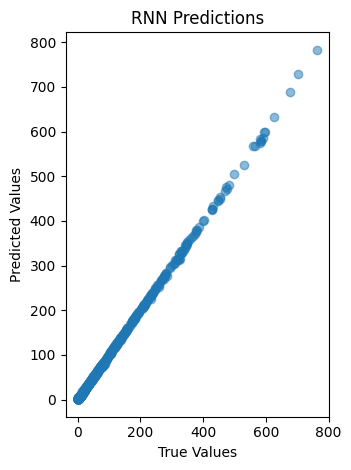

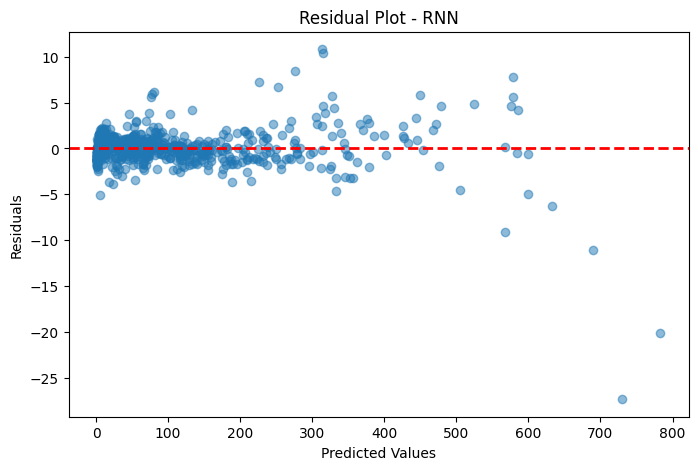

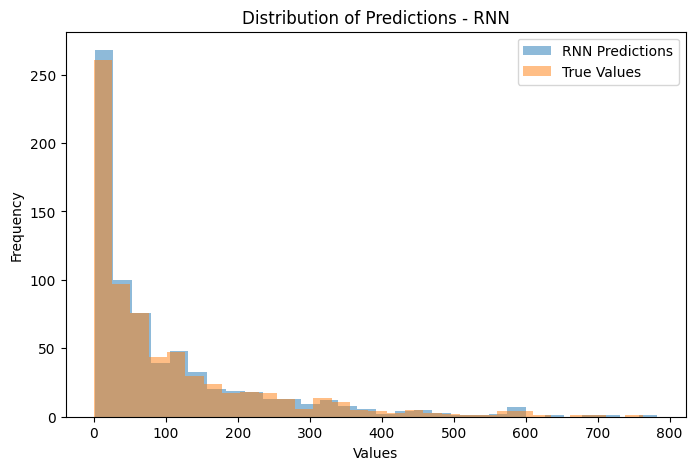

Epoch 1/1000
68/68 [==============================] - 3s 12ms/step - loss: 12394.7461 - mean_squared_error: 12394.7461 - val_loss: 12429.7773 - val_mean_squared_error: 12429.7773
Epoch 2/1000
68/68 [==============================] - 0s 7ms/step - loss: 9151.5654 - mean_squared_error: 9151.5654 - val_loss: 5629.7798 - val_mean_squared_error: 5629.7798
Epoch 3/1000
68/68 [==============================] - 0s 5ms/step - loss: 3107.3623 - mean_squared_error: 3107.3623 - val_loss: 2330.3240 - val_mean_squared_error: 2330.3240
Epoch 4/1000
68/68 [==============================] - 0s 4ms/step - loss: 2349.5925 - mean_squared_error: 2349.5925 - val_loss: 2210.6511 - val_mean_squared_error: 2210.6511
Epoch 5/1000
68/68 [==============================] - 0s 5ms/step - loss: 2208.9622 - mean_squared_error: 2208.9622 - val_loss: 2085.0322 - val_mean_squared_error: 2085.0322
Epoch 6/1000
68/68 [==============================] - 0s 4ms/step - loss: 2050.5955 - mean_squared_error: 2050.5955 - val_los

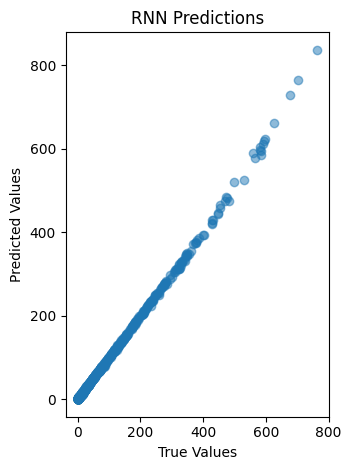

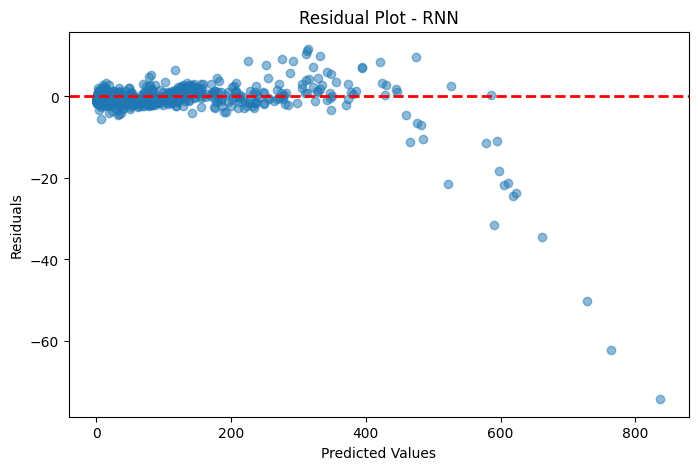

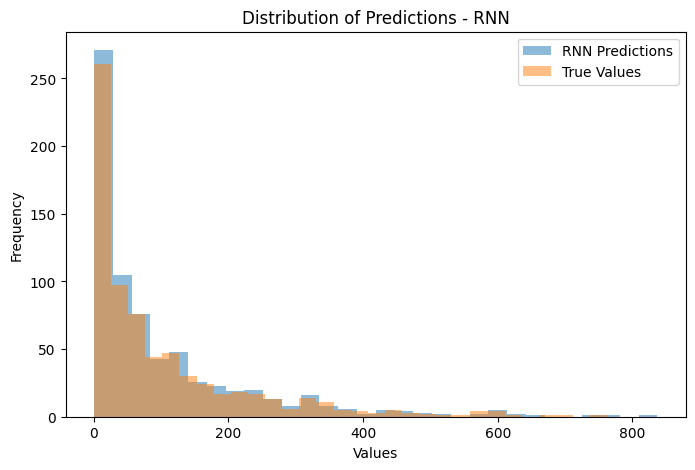

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                21504     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23617 (92.25 KB)
Trainable params: 23617 (92.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #  

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# Constants
FILE_PATH = '/content/all_players_career_stats_2013_2023.csv'
FEATURES = ['FG3A', 'FGA', 'FTA', 'STL', 'TOV', 'PTS']
TARGET = 'AST'
SEED = 42

# Set seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data
def load_data(file_path):
    return pd.read_csv('/content/all_players_career_stats_2018_2023.csv')

# Preprocess data
def preprocess_data(data):
    # Feature engineering
    data['PTS'] = data['PTS'] / data['GP']
    data = data.dropna(subset=FEATURES + [TARGET])
    api_data_array = winsorize(data[FEATURES].values, limits=[0.01, 0.01], axis=0)
    data[FEATURES] = pd.DataFrame(api_data_array, columns=FEATURES)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(data[FEATURES])
    poly_feature_names = poly.get_feature_names_out(FEATURES)
    data_poly = pd.DataFrame(X_poly, columns=poly_feature_names)
    power_transformer = PowerTransformer()
    X_power = power_transformer.fit_transform(data[FEATURES])
    data_power = pd.DataFrame(X_power, columns=FEATURES)
    data = pd.concat([data, data_poly, data_power], axis=1)

    # Prepare data
    exclude_columns = [col for col in data.columns if col not in (FEATURES + [TARGET])]
    X = data.drop(columns=exclude_columns)
    y = data[TARGET].values

    # Standardization using Min-Max Scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)

# Create RNN model
def create_rnn_model(input_shape):
    model = keras.Sequential([
        layers.LSTM(64, activation='relu', input_shape=(None, input_shape)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    return model

# Train RNN model
def train_rnn_model(model, X_train, y_train, epochs=1000, batch_size=32, callbacks=None):
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    # Combine user-provided callbacks with early stopping
    all_callbacks = [early_stopping] if callbacks is None else [early_stopping] + callbacks

    # Reshape input for sequence modeling
    X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

    # Train the model with combined callbacks
    model.fit(
        X_train_reshaped, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_split=0.2,
        callbacks=all_callbacks
    )

# Evaluate RNN model
def evaluate_rnn_model(model, X_test, y_test):
    # Reshape input for sequence modeling
    X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    rnn_pred = model.predict(X_test_reshaped)
    rnn_mse = mean_squared_error(y_test, rnn_pred)
    rnn_rmse = np.sqrt(rnn_mse)
    rnn_mae = mean_absolute_error(y_test, rnn_pred)
    rnn_r2 = r2_score(y_test, rnn_pred)
    return rnn_pred, rnn_mse, rnn_rmse, rnn_mae, rnn_r2

# Plot results
def plot_results_rnn(y_true, y_pred, residual):
    # Scatter Plot for RNN Predictions
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred.flatten(), alpha=0.5)
    plt.title('RNN Predictions')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.tight_layout()

    # Residual Plot for RNN
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred.flatten(), residual, alpha=0.5)
    plt.title('Residual Plot - RNN')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.show()

    # Distribution of Predictions for RNN
    plt.figure(figsize=(8, 5))
    plt.hist(y_pred.flatten(), bins=30, alpha=0.5, label='RNN Predictions')
    plt.hist(y_true, bins=30, alpha=0.5, label='True Values')
    plt.title('Distribution of Predictions - RNN')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Main script
if __name__ == "__main__":
    api_data = load_data(FILE_PATH)
    X_train, X_test, y_train, y_test = preprocess_data(api_data)

    # Apply Isolation Forest to identify and potentially remove outliers from the training data
    iso_forest = IsolationForest(contamination=0.05, random_state=SEED)
    outlier_labels = iso_forest.fit_predict(X_train)
    outlier_indices = np.where(outlier_labels == -1)[0]
    X_train_no_outliers = np.delete(X_train, outlier_indices, axis=0)
    y_train_no_outliers = np.delete(y_train, outlier_indices)

    # Train the RNN model with outliers
    rnn_model_with_outliers = create_rnn_model(X_train.shape[1])
    train_rnn_model(rnn_model_with_outliers, X_train, y_train)

    # Evaluate the model on the test set with outliers
    rnn_pred_with_outliers, rnn_mse_with_outliers, rnn_rmse_with_outliers, rnn_mae_with_outliers, rnn_r2_with_outliers = evaluate_rnn_model(rnn_model_with_outliers, X_test, y_test)

    # Print or use the evaluation metrics for the model with outliers
    print("\nRNN Model Metrics with Outliers:")
    print("MSE:", rnn_mse_with_outliers)
    print("RMSE:", rnn_rmse_with_outliers)
    print("MAE:", rnn_mae_with_outliers)
    print("R-squared:", rnn_r2_with_outliers)

    # Plot results for the model with outliers
    plot_results_rnn(y_test, rnn_pred_with_outliers.flatten(), y_test - rnn_pred_with_outliers.flatten())

    # Train the RNN model without outliers
    rnn_model_no_outliers = create_rnn_model(X_train_no_outliers.shape[1])
    train_rnn_model(rnn_model_no_outliers, X_train_no_outliers, y_train_no_outliers)

    # Evaluate the model on the test set without outliers
    rnn_pred_no_outliers, rnn_mse_no_outliers, rnn_rmse_no_outliers, rnn_mae_no_outliers, rnn_r2_no_outliers = evaluate_rnn_model(rnn_model_no_outliers, X_test, y_test)

    # Print or use the evaluation metrics for the model without outliers
    print("\nRNN Model Metrics without Outliers:")
    print("MSE:", rnn_mse_no_outliers)
    print("RMSE:", rnn_rmse_no_outliers)
    print("MAE:", rnn_mae_no_outliers)
    print("R-squared:", rnn_r2_no_outliers)

    # Plot results for the model without outliers
    plot_results_rnn(y_test, rnn_pred_no_outliers.flatten(), y_test - rnn_pred_no_outliers.flatten())

    # RNN Model Summary
    rnn_model_with_outliers.summary()
    rnn_model_no_outliers.summary()